In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
np.random.seed(7)


import matplotlib.pyplot as plt

from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense, Activation
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.ensemble import RandomForestRegressor


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['train_V2.csv', 'test_V2.csv', 'sample_submission_V2.csv']


## Load train and test data

In [2]:
df_train = pd.read_csv( '../input/train_V2.csv')

In [3]:

df_train = df_train[df_train['winPlacePerc'].notnull()]

print(df_train.shape)

df_test = pd.read_csv( '../input/test_V2.csv')

print(df_test.shape)



(4446965, 29)
(1934174, 28)


## Removing Id related and categorical columns

In [4]:
target = 'winPlacePerc'
features = list(df_train.columns)
features.remove("Id")
features.remove("matchId")
features.remove("groupId")

features.remove("matchType")

y_train = np.array(df_train[target])
features.remove(target)
x_train = df_train[features]

x_test = df_test[features]

print(x_test.shape,x_train.shape,y_train.shape)

(1934174, 24) (4446965, 24) (4446965,)


In [5]:
# Split the train and the validation set for the fitting
random_seed=1
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state=random_seed)

In [6]:
m3 = RandomForestRegressor(n_estimators=50, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1)

In [7]:
%%time
m3.fit(x_train, y_train)



CPU times: user 40min 38s, sys: 7.43 s, total: 40min 45s
Wall time: 20min 45s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [8]:
print('mae train: ', mean_absolute_error(m3.predict(x_train), y_train))
print('mae val: ', mean_absolute_error(m3.predict(x_val), y_val))



mae train:  0.033097349958816705
mae val:  0.05824846131122716


In [9]:
%%time
pred = m3.predict(x_test)
df_test['winPlacePerc'] = pred
submission = df_test[['Id', 'winPlacePerc']]
submission.to_csv('submission_rf.csv', index=False)



CPU times: user 1min 22s, sys: 544 ms, total: 1min 23s
Wall time: 45.2 s


(array([251653., 212963., 202888., 191540., 176397., 165513., 167291.,
        186085., 242257., 137587.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

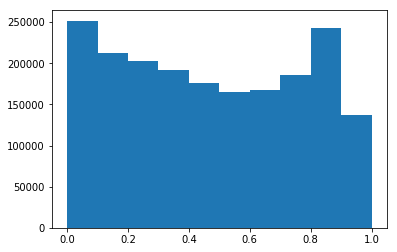

In [10]:
plt.hist(pred)

(array([559538., 436621., 415857., 368876., 347150., 380803., 338666.,
        347439., 384851., 422467.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

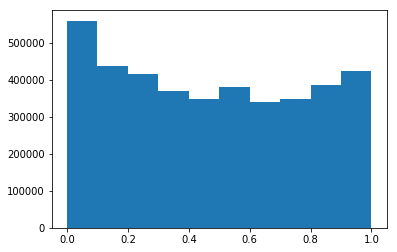

In [11]:
plt.hist(y_train)

In [13]:
from sklearn.metrics import mean_absolute_error

def print_score(m : RandomForestRegressor):
    res = ['mae train: ', mean_absolute_error(m.predict(x_train), y_train)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [14]:
print_score(m3)

['mae train: ', 0.0330973499588167]


In [15]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)
fi = rf_feat_importance(m3, x_train); fi[:10]

,cols,imp
21,walkDistance,0.483447
6,killPlace,0.248709
1,boosts,0.095300
22,weaponsAcquired,0.050426
11,matchDuration,0.017492
13,numGroups,0.015888
10,longestKill,0.015454
5,heals,0.014750
12,maxPlace,0.012809
16,rideDistance,0.008294


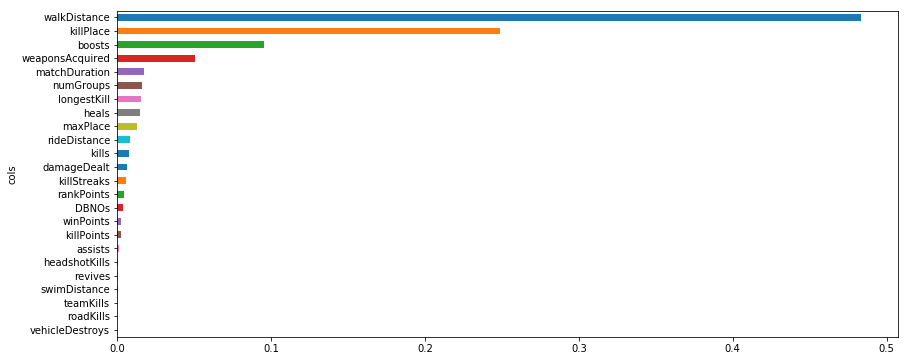

In [16]:
fi_to_keep = rf_feat_importance(m3, x_train)
plot2 = fi_to_keep.plot('cols', 'imp', figsize=(14,6), legend=False, kind = 'barh')
plot2.invert_yaxis()

In [12]:
from sklearn.externals import joblib 

joblib.dump(m3, 'm3.pkl')


['m3.pkl']

In [ ]:
m3_test = joblib.load('m3.pkl')